In [10]:
from __future__ import division, print_function
import numpy as np
import os
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [68]:
from keras.datasets import cifar10
from keras.utils import np_utils

def load_and_preprocess_imgs_brenden():
    save_folder = '../data/images_brenden/'
    shapes = []
    colors = []
    textures = []
    imgs = []
    files = [file for file in os.listdir(save_folder) 
             if file.endswith('jpg') or file.endswith('png')]
    for file in files:
        shape, texture, color = file.split('_')
        color = color[:-4]
        shapes.append(shape)
        textures.append(texture)
        colors.append(color)
        img_path = os.path.join(save_folder, file)
        #img = image.load_img(img_path, target_size=(224, 224))
        img = image.load_img(img_path, target_size=(32, 32))
        imgs.append(image.img_to_array(img))
    imgs = np.asarray(imgs)
    imgs /= 255.
        
    le = LabelEncoder()
    shapes = le.fit_transform(shapes)
    colors = le.fit_transform(colors)
    textures = le.fit_transform(textures)
    
    return imgs, shapes, colors, textures

def data_cifar10():
    """
    Preprocess CIFAR-10 dataset
    """
    # the data, shuffled and split between train and test sets
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255

    Y_train = np_utils.to_categorical(y_train, 10)
    Y_test = np_utils.to_categorical(y_test, 10)

    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [58]:
X, shapes, colors, textures = load_and_preprocess_imgs_brenden()

In [82]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
Y = ohe.fit_transform(shapes.reshape(-1,1))

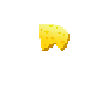

In [85]:
%matplotlib inline
import matplotlib.pylab as plt

plt.figure(figsize=(1,1))
plt.imshow(X[5], interpolation='nearest')
plt.axis('off')
plt.show()

In [88]:
from learning2learn.models import simple_cnn

input_shape = X.shape[1:]
nb_classes = len(np.unique(shapes))
model = simple_cnn(input_shape, nb_classes)
model.fit(X, Y, epochs=80)

Epoch 1/80
80/80 [==============================] - 1s - loss: 20.5907 - acc: 0.1375     
Epoch 2/80
80/80 [==============================] - 0s - loss: 15.5593 - acc: 0.0625     
Epoch 3/80
80/80 [==============================] - 0s - loss: 12.6941 - acc: 0.1875     
Epoch 4/80
80/80 [==============================] - 0s - loss: 10.6238 - acc: 0.1250     
Epoch 5/80
80/80 [==============================] - 0s - loss: 8.9861 - acc: 0.1500     
Epoch 6/80
80/80 [==============================] - 0s - loss: 7.6573 - acc: 0.1125     
Epoch 7/80
80/80 [==============================] - 0s - loss: 6.5653 - acc: 0.1875     
Epoch 8/80
80/80 [==============================] - 0s - loss: 5.6648 - acc: 0.1625     
Epoch 9/80
80/80 [==============================] - 0s - loss: 4.9182 - acc: 0.1750     
Epoch 10/80
80/80 [==============================] - 0s - loss: 4.3310 - acc: 0.1250     
Epoch 11/80
80/80 [==============================] - 0s - loss: 3.8423 - acc: 0.1750     
Epoch 12/80
80/